<a href="https://colab.research.google.com/github/jhihan/Twitter-Sentiment-Analysis/blob/master/tweeter_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
from google.colab import files
import re
import string
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVR, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline

from imblearn.under_sampling import (RandomUnderSampler, 
                                    NearMiss, 
                                    InstanceHardnessThreshold,
                                    CondensedNearestNeighbour,
                                    EditedNearestNeighbours,
                                    RepeatedEditedNearestNeighbours,
                                    AllKNN,
                                    NeighbourhoodCleaningRule,
                                    OneSidedSelection,
                                    TomekLinks)
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
# train_tweets.csv
# test_tweets.csv
uploaded = files.upload()

Saving test_tweets.csv to test_tweets.csv


In [0]:
train = pd.read_csv('train_tweet.csv')
test = pd.read_csv('test_tweets.csv')

In [7]:
print(train.shape)
print(test.shape)

(31962, 3)
(17197, 2)


In [8]:
print(train.head())
print(test.head())

   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation
      id                                              tweet
0  31963  #studiolife #aislife #requires #passion #dedic...
1  31964   @user #white #supremacists want everyone to s...
2  31965  safe ways to heal your #acne!!    #altwaystohe...
3  31966  is the hp and the cursed child book up for res...
4  31967    3rd #bihday to my amazing, hilarious #nephew...


In [9]:
print(train.isnull().any())
print( test.isnull().any())

id       False
label    False
tweet    False
dtype: bool
id       False
tweet    False
dtype: bool


In [10]:
train[train['label'] == 0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [11]:
train[train['label'] == 1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk fol...
77,78,1,"@user hey, white people: you can call people '..."
82,83,1,how the #altright uses &amp; insecurity to lu...
111,112,1,@user i'm not interested in a #linguistics tha...


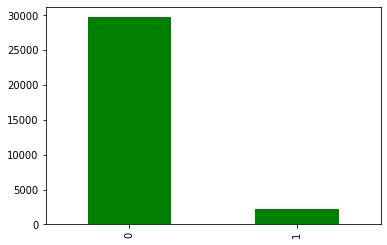

In [13]:
train['label'].value_counts().plot.bar(color = 'green', figsize = (6, 4))

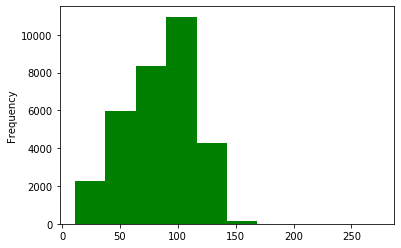

In [14]:
train['tweet'].str.len().plot.hist(color = 'green', figsize = (6, 4))

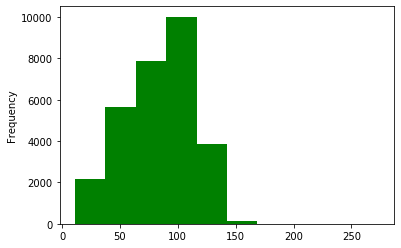

In [15]:
train[train['label'] == 0]['tweet'].str.len().plot.hist(color = 'green', figsize = (6, 4))


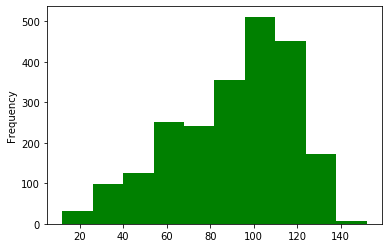

In [16]:
train[train['label'] == 1]['tweet'].str.len().plot.hist(color = 'green', figsize = (6, 4))

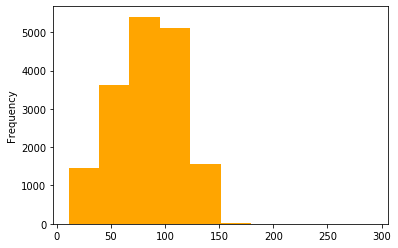

In [14]:
length_test = test['tweet'].str.len().plot.hist(color = 'orange', figsize = (6, 4))

From the above analysis, we know that this is an imbalanced classification problem

In [0]:
# checking the distribution of tweets in the data

#length_train = train['tweet'].str.len().plot.hist(color = 'pink', figsize = (6, 4))
#length_test = test['tweet'].str.len().plot.hist(color = 'orange', figsize = (6, 4))

# adding a column to represent the length of the tweet

train['len'] = train['tweet'].str.len()
test['len'] = test['tweet'].str.len()

In [18]:
train.groupby('label').describe()

id                                   ...   len                    
         count          mean          std   min  ...   25%   50%    75%    max
label                                            ...                          
0      29720.0  15974.454441  9223.783469   1.0  ...  62.0  88.0  107.0  274.0
1       2242.0  16074.896075  9267.955758  14.0  ...  69.0  96.0  111.0  152.0

[2 rows x 16 columns]

In [0]:
original_train = train.copy()
test_original=test.copy()
combine = train.append(test,ignore_index=True,sort=True)

In [20]:
combine.tail(20)

,id,label,len,tweet
49139,49140,NaN,52,i am thankful for children. #thankful #positiv...
49140,49141,NaN,100,liverpool â¤ï¸ð¬ð§ #walk #liverpool #sta...
49141,49142,NaN,109,#bakersfield rooster simulation: i want to c...
49142,49143,NaN,111,por do sol ó¾â¤ï¸#instagood #beautiful #...
49143,49144,NaN,90,@user hell yeah what a great surprise for your...
49144,49145,NaN,53,when ur the joke ur defensive towards everythi...
49145,49146,NaN,96,#enjoying the #evening #sun in my #bedroom â¨...
49146,49147,NaN,106,tonight on @user from 9pm gmt you can here a ...
49147,49148,NaN,88,today is a good day for excercise #imready #so...
49148,49149,NaN,107,good night with a tea and music âï¸ðð...


Begin data preprocessing

In [0]:
# remove pattern
def remove_pattern(text,pattern):
    
    # re.findall() finds the pattern i.e @user and puts it in a list for further task
    r = re.findall(pattern,text)
    
    # re.sub() removes @user from the sentences in the dataset
    for i in r:
        text = re.sub(i,"",text)
    
    return text

In [22]:
combine['Tidy_Tweets'] = np.vectorize(remove_pattern)(combine['tweet'], "@[\w]*")

combine.head()

,id,label,len,tweet,Tidy_Tweets
0,1,0.0,102,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,122,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0.0,21,bihday your majesty,bihday your majesty
3,4,0.0,86,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,39,factsguide: society now #motivation,factsguide: society now #motivation


In [23]:
combine['Tidy_Tweets'] = combine['Tidy_Tweets'].str.replace("[^a-zA-Z#]", " ")
# combine['Tidy_Tweets'] = combine['Tidy_Tweets'].str.replace("[^a-zA-Z#]", " ")
combine.head(10)

,id,label,len,tweet,Tidy_Tweets
0,1,0.0,102,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,122,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can t use cause th...
2,3,0.0,21,bihday your majesty,bihday your majesty
3,4,0.0,86,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,39,factsguide: society now #motivation,factsguide society now #motivation
5,6,0.0,116,[2/2] huge fan fare and big talking before the...,huge fan fare and big talking before the...
6,7,0.0,74,@user camping tomorrow @user @user @user @use...,camping tomorrow danny
7,8,0.0,143,the next school year is the year for exams.ð...,the next school year is the year for exams ...
8,9,0.0,87,we won!!! love the land!!! #allin #cavs #champ...,we won love the land #allin #cavs #champ...
9,10,0.0,50,@user @user welcome here ! i'm it's so #gr...,welcome here i m it s so #gr


In [24]:
tokenized_tweet = combine['Tidy_Tweets'].apply(lambda x: x.split())

tokenized_tweet.head()

0    [when, a, father, is, dysfunctional, and, is, ...
1    [thanks, for, #lyft, credit, i, can, t, use, c...
2                              [bihday, your, majesty]
3    [#model, i, love, u, take, with, u, all, the, ...
4              [factsguide, society, now, #motivation]
Name: Tidy_Tweets, dtype: object

In [0]:
# Stemming
# Stemming is a rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word.
porter = nltk.PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [porter.stem(i).lower() for i in x if i.lower() not in stopwords.words('english')] )

In [26]:
for i in range(len(tokenized_tweet)):
  tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combine['Tidy_Tweets'] = tokenized_tweet
combine.head()

,id,label,len,tweet,Tidy_Tweets
0,1,0.0,102,@user when a father is dysfunctional and is s...,father dysfunct selfish drag kid dysfunct #run
1,2,0.0,122,@user @user thanks for #lyft credit i can't us...,thank #lyft credit use caus offer wheelchair v...
2,3,0.0,21,bihday your majesty,bihday majesti
3,4,0.0,86,#model i love u take with u all the time in ...,#model love u take u time ur
4,5,0.0,39,factsguide: society now #motivation,factsguid societi #motiv


Data visualization after preprocessing

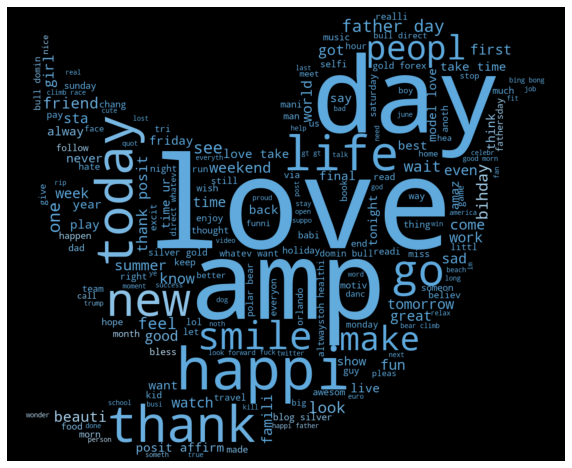

In [27]:
# data visualization after preprocessing:
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests

all_words_positive = ' '.join(text for text in combine['Tidy_Tweets'][combine['label']==0])

# combining the image with the dataset
Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))

# We use the ImageColorGenerator library from Wordcloud 
# Here we take the color of the image and impose it over our wordcloud
image_colors = ImageColorGenerator(Mask)

# Now we use the WordCloud function from the wordcloud library 
wc = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(all_words_positive)

# Size of the image generated 
plt.figure(figsize=(10,20))

# Here we recolor the words from the dataset to the image's color
# recolor just recolors the default colors to the image's blue color
# interpolation is used to smooth the image generated 
plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")

plt.axis('off')
plt.show()

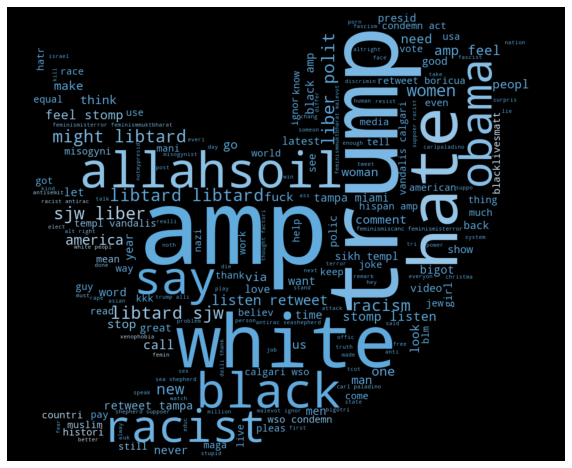

In [28]:
all_words_negative = ' '.join(text for text in combine['Tidy_Tweets'][combine['label']==1])

# combining the image with the dataset
Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))

# We use the ImageColorGenerator library from Wordcloud 
# Here we take the color of the image and impose it over our wordcloud
image_colors = ImageColorGenerator(Mask)

# Now we use the WordCloud function from the wordcloud library 
wc = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(all_words_negative)

# Size of the image generated 
plt.figure(figsize=(10,20))

# Here we recolor the words from the dataset to the image's color
# recolor just recolors the default colors to the image's blue color
# interpolation is used to smooth the image generated 
plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")

plt.axis('off')
plt.show()

**Visualization of the effect of Hashtag**

In [0]:
# collect hashtag
def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [0]:
# extracting hashtags from non racist/sexist tweets
HT_regular = hashtag_extract(combine['Tidy_Tweets'][combine['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(combine['Tidy_Tweets'][combine['label'] == 1])

#unnest
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])


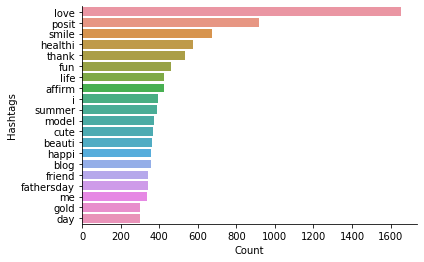

In [31]:
word_freq_regular = nltk.FreqDist(HT_regular)

df_positive = pd.DataFrame({'Hashtags':list(word_freq_regular.keys()),'Count':list(word_freq_regular.values())})


df_positive_plot = df_positive.nlargest(20,columns='Count')

sns.barplot(data=df_positive_plot,y='Hashtags',x='Count')
sns.despine()

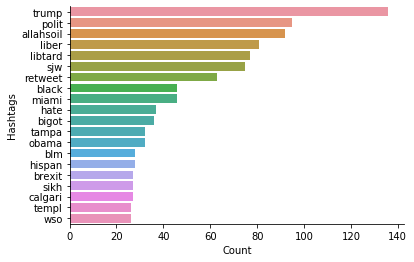

In [32]:
word_freq_negative = nltk.FreqDist(HT_negative)

df_negative = pd.DataFrame({'Hashtags':list(word_freq_negative.keys()),'Count':list(word_freq_negative.values())})


df_negative_plot = df_negative.nlargest(20,columns='Count')

sns.barplot(data=df_negative_plot,y='Hashtags',x='Count')
sns.despine()

**Data split**

In [33]:
print(combine['Tidy_Tweets'])

0           father dysfunct selfish drag kid dysfunct #run
1        thank #lyft credit use caus offer wheelchair v...
2                                           bihday majesti
3                             #model love u take u time ur
4                                 factsguid societi #motiv
                               ...                        
49154    thought factori left right polaris #trump #use...
49155    feel like mermaid #hairflip #neverreadi #forma...
49156    #hillari #campaign today #ohio omg amp use wor...
49157    happi work confer right mindset lead cultur de...
49158    song glad free download #shoegaz #newmus #newsong
Name: Tidy_Tweets, Length: 49159, dtype: object


In [0]:
x_train = combine['Tidy_Tweets'][:31962]
y_train = combine['label'][:31962]
x_test = combine['Tidy_Tweets'][31962:]


In [0]:
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train,y_train,test_size=0.2,random_state=17,stratify=y_train)

**Building model**

We will build up the training model. In addition to the baseline model which is build by dummy calssifier, we will build up the models with and without re-sampling techniques. Here the re-sampling technique we will use is Tomek Link Removal.

Baseline model

In [38]:
model_base = []

# first model is the dummy model
param_grid = [{ 'vect__max_df':[0.85  ],
                'vect__min_df':[2],
                'vect__max_features':[1000],
                'vect__stop_words':['english'],
                'dummy__strategy': ['stratified','most_frequent','prior','uniform','constant']
              } ]

dummy_tfidf = Pipeline( [('vect', TfidfVectorizer())  , ('dummy', DummyClassifier() ) ] )
model_base = GridSearchCV( dummy_tfidf, param_grid, scoring= 'f1', cv=5, n_jobs=-1)
model_base.fit(x_train_split, y_train_split)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [39]:
print("baseline model:")
print("best parameters", model_base.best_params_)
print("best scores", model_base.best_score_)
prediction = model_base.predict( x_val_split )
f1_score_base =  f1_score(y_val_split , prediction)
print( "f1-score of the test data", f1_score_base  )

baseline model:
best parameters {'dummy__strategy': 'uniform', 'vect__max_df': 0.85, 'vect__max_features': 1000, 'vect__min_df': 2, 'vect__stop_words': 'english'}
best scores 0.12379691893544549
f1-score of the test data 0.12107990182710662


In [40]:
pd.crosstab(y_val_split , prediction, rownames=['label'], colnames=['prediction'] )

prediction,0.0,1.0
label,,
0.0,2948,2997
1.0,226,222


Logistic regression

In [41]:
model_lr = []
param_grid = [{ 'vect__max_df':[0.85  ],
                'vect__min_df':[2],
                'vect__max_features':[1000],
                'vect__stop_words':['english'],
                'clf__penalty':['l1','l2'],
                'clf__C': [  0.001, 0.01, 0.1, 1.0 ]
              } ]
lr_tfidf = Pipeline( [('vect', TfidfVectorizer()) , ('std', StandardScaler(with_mean=False)) , ('clf', LogisticRegression(random_state=0) ) ] )
model_lr.append( GridSearchCV( lr_tfidf, param_grid, scoring= 'f1', cv=5, n_jobs=-1) )

param_grid = [{ 'vect__max_df':[0.85  ],
                'vect__min_df':[2],
                'vect__max_features':[1000],
                'vect__stop_words':['english'],
                'sampling__ratio':['majority'],
                'clf__penalty':['l1','l2'],
#                'clf__class_weight':[{ 1:0.5, 0:0.5 }  ,  { 1:0.75, 0:0.25 } ,  { 1:0.8, 0:0.2 }, { 1:0.9, 0:0.1 }],
                'clf__C': [ 0.001, 0.01, 0.1, 1.0 ]
              } ]
lr_TomekLinks_tfidf = Pipeline( [('vect', TfidfVectorizer()) , ('sampling', TomekLinks()), ('std', StandardScaler(with_mean=False)) , ('clf', LogisticRegression(random_state=0) ) ] )
model_lr.append( GridSearchCV( lr_TomekLinks_tfidf, param_grid, scoring= 'f1', cv=5, pre_dispatch = 'n_jobs',n_jobs=-1) )

for model in model_lr:
  model.fit(x_train_split, y_train_split)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [42]:
print("Logistic Regression:")
f1_score_lr = []
for i,model in enumerate(model_lr):
  if(i == 1):
    print("With Tomek Links removal under-sampling method:")
  print("best parameters", model.best_params_)
  print("best scores", model.best_score_)
  prediction = model.predict( x_val_split )
  f1_score_lr.append( f1_score(y_val_split , prediction) )
  print( "f1-score of the test data", f1_score_lr[i] )

Logistic Regression:
best parameters {'clf__C': 0.1, 'clf__penalty': 'l2', 'vect__max_df': 0.85, 'vect__max_features': 1000, 'vect__min_df': 2, 'vect__stop_words': 'english'}
best scores 0.5411350201209497
f1-score of the test data 0.5587828492392808
With Tomek Links removal under-sampling method:
best parameters {'clf__C': 0.01, 'clf__penalty': 'l2', 'sampling__ratio': 'majority', 'vect__max_df': 0.85, 'vect__max_features': 1000, 'vect__min_df': 2, 'vect__stop_words': 'english'}
best scores 0.5437581184506347
f1-score of the test data 0.5552407932011332


In [45]:
for i,model in enumerate(model_lr):
  if(i == 1):
    print("With Tomek Links removal under-sampling method:")
  prediction = model.predict( x_val_split )
  print("-------")
  print( pd.crosstab(y_val_split , prediction, rownames=['label'], colnames=['prediction'] )  )

-------
prediction   0.0  1.0
label                
0.0         5872   73
1.0          246  202
With Tomek Links removal under-sampling method:
-------
prediction   0.0  1.0
label                
0.0         5883   62
1.0          252  196


Support vector machine

In [47]:
model_svm = []
param_grid=[ 
    {
     'vect__max_df':[0.85  ],
     'vect__min_df':[2],
     'vect__max_features':[1000],
     'vect__stop_words':['english'],
     'svm__kernel': ['rbf'],
     'svm__C': [ 1e0, 1e1, 1e2, 1e3 ],
     'svm__gamma' : [1e-5, 1e-4, 1e-3 ],
     }]
svm_pipe_tfidf = Pipeline( [ ('vect', TfidfVectorizer()),('std', StandardScaler(with_mean=False)) , ('svm', SVC() ) ] )

model_svm.append( GridSearchCV(svm_pipe_tfidf, param_grid, scoring= 'f1', cv=5,pre_dispatch = 'n_jobs', n_jobs=-1) )

param_grid=[ 
    {
     'vect__max_df':[0.85  ],
     'vect__min_df':[2],
     'vect__max_features':[1000],
     'vect__stop_words':['english'],
     'sampling__ratio':['majority'],
     'svm__kernel': ['rbf'],
     'svm__C': [ 1e0, 1e1, 1e2, 1e3 ],
     'svm__gamma' : [1e-5, 1e-4, 1e-3 ],
     }]
svm_pipe_TomekLinks_tfidf = Pipeline( [ ('vect', TfidfVectorizer()), ('sampling', TomekLinks()),('std', StandardScaler(with_mean=False)) , ('svm', SVC() ) ] )
model_svm.append( GridSearchCV(svm_pipe_TomekLinks_tfidf, param_grid, scoring= 'f1', cv=5, pre_dispatch = 'n_jobs', n_jobs=-1) )

for model in model_svm:
  model.fit(x_train_split, y_train_split)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [48]:
print("Support vector machine:")
f1_score_svm = []
for i,model in enumerate(model_svm):
  if(i == 1):
    print("With Tomek Links removal under-sampling method:")
  print("best parameters", model.best_params_)
  print("best scores", model.best_score_)
  prediction = model.predict( x_val_split )
  f1_score_svm.append( f1_score(y_val_split , prediction) )
  print( "f1-score of the test data", f1_score_svm[i] )

Support vector machine:
best parameters {'svm__C': 100.0, 'svm__gamma': 0.0001, 'svm__kernel': 'rbf', 'vect__max_df': 0.85, 'vect__max_features': 1000, 'vect__min_df': 2, 'vect__stop_words': 'english'}
best scores 0.5930548480769346
f1-score of the test data 0.6251691474966171
With Tomek Links removal under-sampling method:
best parameters {'sampling__ratio': 'majority', 'svm__C': 100.0, 'svm__gamma': 0.0001, 'svm__kernel': 'rbf', 'vect__max_df': 0.85, 'vect__max_features': 1000, 'vect__min_df': 2, 'vect__stop_words': 'english'}
best scores 0.5938843444638551
f1-score of the test data 0.6273458445040214


In [49]:
for i,model in enumerate(model_svm):
  if(i == 1):
    print("With Tomek Links removal under-sampling method:")
  prediction = model.predict( x_val_split )
  print("-------")
  print( pd.crosstab(y_val_split , prediction, rownames=['label'], colnames=['prediction'] )  )

-------
prediction   0.0  1.0
label                
0.0         5885   60
1.0          217  231
With Tomek Links removal under-sampling method:
-------
prediction   0.0  1.0
label                
0.0         5881   64
1.0          214  234


Random forest

In [0]:
model_rf = []
param_grid = [{ 'vect__max_df':[0.85  ],
                'vect__min_df':[2],
                'vect__max_features':[1000],
                'vect__stop_words':['english'],
                'rfc__max_depth': [50,53,56,59,62],
                'rfc__min_samples_split': [2]
              }]
rfc_tfidf = Pipeline( [('vect', TfidfVectorizer()) , ('rfc',RandomForestClassifier(random_state=1) ) ] )
model_rf.append( GridSearchCV( rfc_tfidf, param_grid, scoring= 'f1', cv=5, n_jobs=-1) )

param_grid = [{ 'vect__max_df':[0.85  ],
                'vect__min_df':[2],
                'vect__max_features':[1000],
                'vect__stop_words':['english'],
                'sampling__ratio':['majority'],
                'rfc__max_depth': [50,53,56,59,62],
                'rfc__min_samples_split': [2]
              }]
rfc_TomekLinks_tfidf = Pipeline( [('vect', TfidfVectorizer()) , ('sampling', TomekLinks()), ('rfc',RandomForestClassifier(random_state=1) ) ] )
model_rf.append( GridSearchCV( rfc_TomekLinks_tfidf, param_grid, scoring= 'f1', cv=5, pre_dispatch = 'n_jobs', n_jobs=-1 ) )

for model in model_rf:
  model.fit(x_train_split, y_train_split)


In [0]:
print("Random forest:")
f1_score_rf = []
for i,model in enumerate(model_rf):
  if(i == 1):
    print("With Tomek Links removal under-sampling method:")
  print("best parameters", model.best_params_)
  print("best scores", model.best_score_)
  prediction = model.predict( x_val_split )
  f1_score_rf.append( f1_score(y_val_split , prediction) )
  print( "f1-score of the test data", f1_score_rf[i] )

In [0]:
for i,model in enumerate(model_rf):
  if(i == 1):
    print("With Tomek Links removal under-sampling method:")
  prediction = model.predict( x_val_split )
  print("-------")
  print( pd.crosstab(y_val_split , prediction, rownames=['label'], colnames=['prediction'] )  )

**Comparison between different estimators:**

In [52]:
column_names = ['Without resampling','Tomek-link undersampling']
comparison = pd.DataFrame(columns = column_names)
comparison.loc['baseline'] = [f1_score_base,f1_score_base]
comparison.loc['LogisticReg'] = [f1_score_lr[0],f1_score_lr[1]]
comparison.loc['SVM'] = [f1_score_svm[0],f1_score_svm[1]]
#comparison.loc['RandomForest'] = 
comparison

,Without resampling,Tomek-link undersampling
baseline,0.121080,0.121080
LogisticReg,0.558783,0.555241
SVM,0.625169,0.627346


Conclusion:
The right choice of the re-sampling methods can really help us to get better prediction results, but the difference are still within the error range. In the next version, more under-sampling methods and the over-sampling methods will be also taken into consideration. Actually, I have run the over-sampling methods "BorderlineSMOTE" with logistic regression before. I can tell you that the performance becomes worse......The other problem of over-sampling methods is that the increasement of the data make some classifiers much slower, such as support vector machine. Therefore, the wrong choice of the over-sampling methods can make both the efficiency and the performance worse.